# Метод обратного распространения ошибки для двухслойной полносвязанной нейронной сети

In [58]:
import numpy as np
from matplotlib import pyplot as plt
import time
import random
from random import randint
import torch
import torch.nn
import torch.utils.data
import torchvision.datasets
import torchvision.transforms
from torchvision.transforms import ToTensor
import os
from datetime import timedelta
from time import perf_counter
import math

## Загрузка датасета и определение корректности его загрузки

Number of train samples: 60000
Number of test samples: 10000


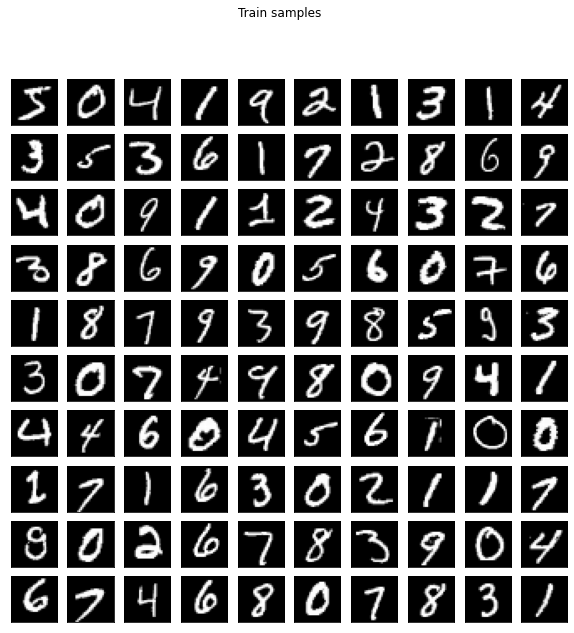

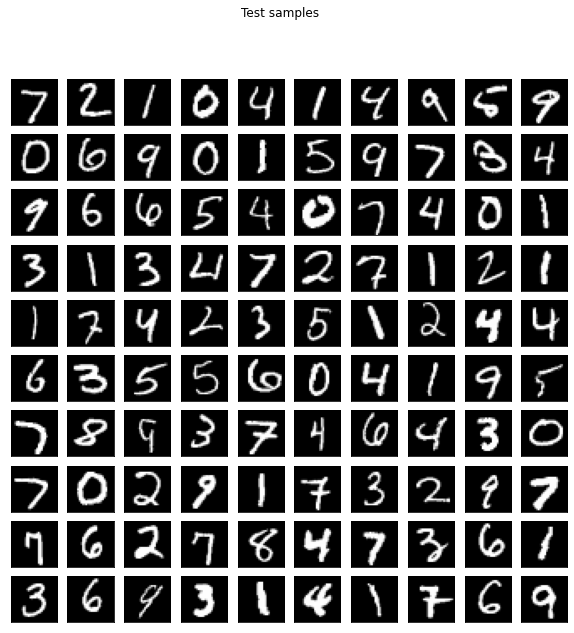

In [15]:
dir_name = os.getcwd()
batch_size = 32

def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (10, 10)
    fig, axes = plt.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plt.setp(plt.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = images[i][0].numpy().transpose(1, 2, 0).squeeze(axis = 2)
        ax.imshow(img, cmap = 'gray')

train_dataset = torchvision.datasets.MNIST(
    root = dir_name, train = True, download = True,
    transform = torchvision.transforms.ToTensor()
)
test_dataset = torchvision.datasets.MNIST(
    root = dir_name, train = False, download = True,
    transform = torchvision.transforms.ToTensor()
)

print('Number of train samples: {}'.format(len(train_dataset)))
show_images(train_dataset, 'Train samples')

print('Number of test samples: {}'.format(len(test_dataset)))
show_images(test_dataset, 'Test samples')

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [19]:
train_dataset[0][0].shape

0

In [ ]:
test_dataset[0][0].shape

In [20]:
train_dataset[1][1]

0

#### Объявление всех необходимых переменных

In [21]:
image_size = 28*28
class_num = 10
neurons = 300
learning_rate = 0.1
epochs = 20

## Сеть из фреймворка torch

#### Инициализация и объявление модели

In [24]:
class TorchModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TorchModel, self).__init__()
        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        return out

torch_model = TorchModel(image_size, neurons, class_num)

#### Объявление необходимых функций

In [31]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(torch_model.parameters(), lr = learning_rate)

def get_accuracy(data_loader, model):
    tp = 0
    count = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.reshape(-1, image_size)
            outputs = model(images)
            count += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            tp += (predicted == labels).sum()
    return tp / count

#### Этап основных вычислений

In [50]:
for epoch in range(epochs):
    time_one = perf_counter()
    for images, labels in train_data_loader:
        images = images.view(-1, image_size).requires_grad_()
        outputs = torch_model(images)
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    time_two = perf_counter()
    time = time_two-time_one
    accuracy = get_accuracy(train_data_loader, torch_model)
    print('Эпоха[{}]: точность = {}, время выполнения = {}'.format(epoch, get_accuracy(train_data_loader, torch_model), time))

accuracy_test = get_accuracy(test_data_loader, torch_model)
print('Тестовая точность: {}'.format(accuracy_test))

Эпоха[0]: точность = 0.9969333410263062, время выполнения = 15.60804890000145
Эпоха[1]: точность = 0.9981499910354614, время выполнения = 16.19101860000228
Эпоха[2]: точность = 0.9978500008583069, время выполнения = 19.11230280000018
Эпоха[3]: точность = 0.9988666772842407, время выполнения = 18.96865539999999
Эпоха[4]: точность = 0.9989833235740662, время выполнения = 16.955251499999576
Эпоха[5]: точность = 0.9994833469390869, время выполнения = 17.92247370000041
Эпоха[6]: точность = 0.9994500279426575, время выполнения = 17.715520499998092
Эпоха[7]: точность = 0.9995499849319458, время выполнения = 16.668714600000385
Эпоха[8]: точность = 0.9994833469390869, время выполнения = 16.89774849999958
Эпоха[9]: точность = 0.9995999932289124, время выполнения = 16.643216699998447
Эпоха[10]: точность = 0.9997833371162415, время выполнения = 16.452558000000863
Эпоха[11]: точность = 0.9997666478157043, время выполнения = 17.626218000001245
Эпоха[12]: точность = 0.9998499751091003, время выполнен

## Рукописная сеть :)

In [112]:
def ReLU(x):
    return torch.ReLU()

def ReLU_d(x):
    return x > 0

def softmax(x):
    return torch.softmax(x, 1)

In [140]:
class MyModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, classes_size, learning_rate, batch_size):
        super(MyModel, self).__init__()
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.classes_size = classes_size
        self.weights_input_hidden = torch.zeros([self.hidden_size, self.input_size], dtype=torch.float32)
        self.b_hid = torch.zeros([self.hidden_size, 1], dtype=torch.float32)
        self.weights_hidden_output = torch.zeros([self.classes_size, self.hidden_size], dtype=torch.float32)
        self.b_out = torch.zeros([self.classes_size, 1], dtype=torch.float32)
        torch.nn.init.xavier_uniform_(self.weights_input_hidden)
        torch.nn.init.zeros_(self.b_hid)
        torch.nn.init.xavier_uniform_(self.weights_hidden_output)
        torch.nn.init.zeros_(self.b_out)

        
    def forward(self, images):
        self.linear0 = (images@self.weights_input_hidden.transpose(0, 1)) + self.b_hid.transpose(0, 1)
        self.relu_value = torch.relu(self.linear0)
        self.linear1 = (self.relu_value@self.weights_hidden_output.transpose(0, 1)) + self.b_out.transpose(0, 1)
        self.softmax_vaue = softmax(self.linear1)
        self.images = images
        return self.softmax_vaue

    def backward(self, labels):
        labels_new = torch.zeros_like(self.softmax_vaue)
        for size in range(labels.shape[0]):
            labels_new[size, labels[size]] = 1
        d_u = (self.softmax_vaue - labels_new)/labels.shape[0]
        d_w0 = d_u.transpose(0, 1)@self.relu_value
        self.weights_hidden_output -= self.learning_rate * d_w0
        self.b_out -= self.learning_rate * d_u.sum(0).unsqueeze(-1)
        
        d_v = torch.mul(d_u @ self.weights_hidden_output, self.linear0 > 0)
        d_w1 = d_v.transpose(0, 1)@self.images
        self.weights_input_hidden -= self.learning_rate * d_w1
        self.b_hid -= self.learning_rate * d_v.sum(0).unsqueeze(-1)

In [141]:
my_model = MyModel(image_size, neurons, class_num, learning_rate, batch_size)

#### Этап основных вычислений

In [142]:
for epoch in range(epochs):
    time_one = perf_counter()
    for images, labels in train_data_loader:
        images = images.view(-1, image_size).requires_grad_()
        my_model.forward(images)
        my_model.backward(labels)

    time_two = perf_counter()
    time = time_two-time_one
    accuracy = get_accuracy(train_data_loader, torch_model)
    print('Эпоха[{}]: точность = {}, время выполнения = {}'.format(epoch, get_accuracy(train_data_loader, torch_model), time))

accuracy_test = get_accuracy(test_data_loader, torch_model)
print('Тестовая точность: {}'.format(accuracy_test))

Эпоха[0]: точность = 0.9999666810035706, время выполнения = 15.230072800000926
Эпоха[1]: точность = 0.9999666810035706, время выполнения = 15.83939509999982
Эпоха[2]: точность = 0.9999666810035706, время выполнения = 15.833463999999367
Эпоха[3]: точность = 0.9999666810035706, время выполнения = 16.8075820999984
Эпоха[4]: точность = 0.9999666810035706, время выполнения = 16.570016300000134
Эпоха[5]: точность = 0.9999666810035706, время выполнения = 17.396035499998106
Эпоха[6]: точность = 0.9999666810035706, время выполнения = 17.92988559999867
Эпоха[7]: точность = 0.9999666810035706, время выполнения = 16.98658240000077
Эпоха[8]: точность = 0.9999666810035706, время выполнения = 16.900099699996645
Эпоха[9]: точность = 0.9999666810035706, время выполнения = 17.070921800001088
Эпоха[10]: точность = 0.9999666810035706, время выполнения = 17.719863400001486
Эпоха[11]: точность = 0.9999666810035706, время выполнения = 17.532427199999802
Эпоха[12]: точность = 0.9999666810035706, время выполне